# https://github.com/ChangYungHua/Latent-space-AR

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import os 

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import random


2021-10-12 19:13:39.632490: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
from iosdata.digital_printing_defects import DigitalPrintingDefects
from torchvision.transforms import transforms


for clazz in ["IMG_4", "IMG_8", "IMG_6", "IMG_22", "IMG_10", "IMG_11" , "IMG_12", "IMG_16" , "IMG_20", "IMG_25"]:
    trans = [transforms.ToTensor()]
    X_, X_valid_, X_test_ = DigitalPrintingDefects(clazz, z_normalize=False, transform=transforms.Compose(trans), patch_size=96, stride=96)[0]
    
    X_ = X_[np.random.permutation(range(len(X_)))[:1000]]
    X_valid_ = X_valid_[np.random.permutation(range(len(X_test_)))[:1000]]
    X_test_ = X_test_[np.random.permutation(range(len(X_test_)))[:1000]]
    
    np.save(f"./data/{clazz}_X96", X_)
    np.save(f"./data/{clazz}_X_val96", X_valid_)
    np.save(f"./data/{clazz}_X_test96", X_test_)

In [2]:
'''
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

'''
version = tf.__version__
gpu_ok = tf.test.is_gpu_available()

print("tf version:",version,"\nuse GPU",gpu_ok)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
tf version: 2.5.0 
use GPU True


2021-10-12 19:13:40.844943: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-12 19:13:40.847542: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-12 19:13:41.343274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 19:13:41.343881: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:01.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-10-12 19:

In [5]:

clazz = "IMG_4"
X_ = np.load(f"./data/{clazz}_X96.npy")
X_valid_ = np.load(f"./data/{clazz}_X_val96.npy")
X_test_ = np.load(f"./data/{clazz}_X_test96.npy")


x_train = X_[100:]
x_val = X_[:100]

x_test = np.vstack([ X_valid_, X_test_])
y_test = np.concatenate([np.zeros(len(X_valid_)), np.ones(len(X_valid_))])

img_size = 96
x_train_d = x_train.reshape((-1, 3, img_size * img_size))[:, 0:3, :].transpose(0,2,1).copy().reshape(-1, 3*img_size*img_size).copy()
x_test_d = x_test.reshape((-1, 3, img_size * img_size))[:, 0:3, :].transpose(0,2,1).copy().reshape(-1, 3*img_size*img_size).copy()
x_val_d = x_val.reshape((-1, 3, img_size * img_size))[:, 0:3, :].transpose(0,2,1).copy().reshape(-1, 3*img_size*img_size).copy()


train_buf = x_train.shape[0]
print(x_train.shape)
print(train_buf)

batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

(900, 27648)
900


2021-10-12 19:14:05.112951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 19:14:05.113663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:01.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-10-12 19:14:05.113777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 19:14:05.114339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 19:14:05.114836: I tensorflow/core/common_runtime/gpu/

In [4]:
print("Loading data...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size = 0.33, random_state = 42)
x_train = x_train[y_train==3]
x_val = x_val[y_val==3]

img_size = x_train.shape[1]
x_train = x_train.reshape((-1, img_size * img_size))

x_test = x_test.reshape((-1, img_size * img_size))


train_buf = x_train.shape[0]
print(x_train.shape)
print(train_buf)
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

Loading data...
(4096, 784)
4096


2021-10-12 18:36:51.596243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 18:36:51.596900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:01.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-10-12 18:36:51.597062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 18:36:51.597629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 18:36:51.598115: I tensorflow/core/common_runtime/gpu/

In [6]:
n, p = x_train.shape
c = 3
d = 32
B = 100 # Bin
fm_list = [32, 32, 32, 32]

In [7]:
def downsampleblock(input_, h_dim):
    x = tf.keras.layers.Conv2D(h_dim, (3, 3), strides = 1, padding='same', use_bias = True)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(h_dim, (1, 1), strides = 2, padding='valid', use_bias = True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    y = tf.keras.layers.Conv2D(h_dim, (3, 3), strides = 2, padding='same', use_bias = True)(input_)
    y = tf.keras.layers.BatchNormalization()(y)
    
    o = tf.keras.layers.Add()([x, y])
    o = tf.keras.layers.LeakyReLU()(o)
    return o

def upsampleblock(input_, h_dim):
    x = tf.keras.layers.Conv2DTranspose(h_dim, (5, 5), strides=1, padding='same', use_bias = True)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(h_dim, (1, 1), strides=2, padding='same', use_bias = True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    y = tf.keras.layers.Conv2D(h_dim, (3, 3), strides=1, padding='same', use_bias = True)(input_)
    y = tf.keras.layers.UpSampling2D((2, 2))(y)
    y = tf.keras.layers.BatchNormalization()(y)
    
    o = tf.keras.layers.Add()([x, y])
    o = tf.keras.layers.LeakyReLU()(o)
    return o

def residualblock(input_):
    x = tf.keras.layers.Conv2D(h_dim[0], (3, 3), strides=1, padding='same')(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(h_dim[0], (3, 3), strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    o = tf.keras.layers.Add()([x, input_])
    o = tf.keras.layers.LeakyReLU()(o)
    return o

In [8]:
def MaskedFullyConnection(x, w, mask_type = 'B'):

    _, d, c_in = x.shape
    d_co, _ = w.shape  #w.shape = (c_out*d) * (c_in*d)
    c_out = d_co//d

    x = tf.reshape(x, [-1, d * c_in] )

    mask_0 = tf.zeros_like(w)
    mask_1 = tf.ones_like(w)
    j = 0
    for f in range(d):
        start_row = f * c_out
        end_row = (f+1) * c_out
        start_col = 0
        end_col = f * c_in if mask_type == 'A' else (f+1) * c_in
        '''相當於mask[start_row:end_row, start_col:end_col] = 1；其他是0 '''
        sub_mask_1 = mask_1[start_row:end_row, start_col:end_col]
        sub_mask_0 = mask_0[start_row:end_row, end_col:]
        sub_mask = tf.concat([sub_mask_1,sub_mask_0], axis = 1)
        if j==0:
            mask = sub_mask
        else:
            mask = tf.concat([mask,sub_mask], axis = 0)
        j = j + 1
    mask_w = tf.multiply(mask, w)
    mask_w = tf.transpose(mask_w, [1,0]) #(c_in*d) * (c_out*d)
    output = tf.matmul(x, mask_w)
    output = tf.reshape(output, [-1, d , c_out] ) ##x = N*d*c
    

                            
    return output

In [9]:
class MFC(layers.Layer):
    def __init__(self, mask_type = 'B', c_in = 1, c_out = 5, latent_dim = d):
        super(MFC, self).__init__()
        self.w = self.add_weight(shape=(latent_dim * c_out, latent_dim * c_in), initializer='random_normal', trainable=True)
        self.type = mask_type
    def call(self, inputs):
        output = MaskedFullyConnection(inputs, self.w, self.type )
        output = tf.nn.relu(output)
        return output


In [79]:
def make_encoder():

    inputs = tf.keras.Input(shape=(p,), name='inputs')
    x = tf.reshape(inputs, shape = (-1, img_size, img_size, c))
    #print(x.shape)
    x = downsampleblock(x, d)
    #print(x.shape)
    x = downsampleblock(x, d)
    
    x = downsampleblock(x, d)
    
    x = downsampleblock(x, d)
    
    #print(x.shape)
    x = tf.reshape(x, shape = (-1, 6 * 6 * d))
    
    #x = tf.reshape(x, shape = (-1, 7 * 7 * d))
    #print(x.shape)
    
    x = tf.keras.layers.Dense(d*2)(x)
    #print(x.shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(d, activation='sigmoid')(x)
    #print(x.shape)
    print("")
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model    
   
def make_decoder():

    inputs = tf.keras.Input(shape=(d,), name='inputs')
    #print(inputs.shape)
    x = tf.keras.layers.Dense(d*2)(inputs)
    #print(x.shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(d*6*6)(x)
    #x = tf.keras.layers.Dense(d*7*7)(x)
    #print(x.shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    #x = tf.reshape(x, shape = (-1, 7, 7, d))
    x = tf.reshape(x, shape = (-1, 6, 6, d))
    
    x = upsampleblock(x, d)
    x = upsampleblock(x, d)
    #print(x.shape)
    x = upsampleblock(x, d)
    #print(x.shape)
    x = upsampleblock(x, d)
    #print(x.shape)
    x = tf.keras.layers.Conv2D(c, (1, 1), strides=1, padding='same')(x)
    #print(x.shape)
    x = tf.reshape(x, shape = (-1, p))
    #print(x.shape)
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model 
        
        
def make_estimator():      
    inputs = tf.keras.Input(shape=(d,), name='inputs')
    print('make_estimator')

    x = tf.expand_dims(inputs, axis=2)
    #print(x.shape)
    x = MFC('A', 1, fm_list[0])(x)
    #print(x.shape)
    x = MFC('B',fm_list[0],fm_list[1])(x)
    #print(x.shape)
    x = MFC('B',fm_list[1],fm_list[2])(x)
    #print(x.shape)
    x = MFC('B',fm_list[2],fm_list[3])(x)
    #print(x.shape)
    x = MFC('B',fm_list[3],B)(x)
    #print(x.shape)
    x = tf.nn.softmax(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

encoder = make_encoder()
decoder = make_decoder()
estimator = make_estimator()


make_estimator


In [11]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 27648)]      0                                            
__________________________________________________________________________________________________
tf.reshape (TFOpLambda)         (None, 96, 96, 3)    0           inputs[0][0]                     
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   896         tf.reshape[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 32)   128         conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 64)           256         dense_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 64)           0           batch_normalization_10[0][0]     
____________________________________________________________________________________________

In [13]:
estimator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 32)]              0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 32, 1)             0         
_________________________________________________________________
mfc (MFC)                    (None, 32, 32)            32768     
_________________________________________________________________
mfc_1 (MFC)                  (None, 32, 32)            1048576   
_________________________________________________________________
mfc_2 (MFC)                  (None, 32, 32)            1048576   
_________________________________________________________________
mfc_3 (MFC)                  (None, 32, 32)            1048576   
_________________________________________________________________
mfc_4 (MFC)                  (None, 32, 100)           3276

In [14]:
REC_loss_weight = 1
LLK_loss_weight = 0.01

cross_entropy = tf.keras.losses.CategoricalCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def REC_loss(inputs, reconstruction):
    return  mse(inputs, reconstruction)

def LLK_loss(z, z_dist):
    '''
    z : encoder後的結果 N * d (hidden layer units)  
    z_dist : autoregressive後的結果 N * d * B 
    
    '''
    eps = 1e-16
    batch = z.shape[0]
    z_dist = tf.clip_by_value(z_dist, eps, 1 - eps)
    log_z_dist = tf.math.log(z_dist)

    indices = tf.histogram_fixed_width_bins(z, [0.0, 1.0], nbins = B)
    indices = tf.one_hot(indices, B)

    loss = cross_entropy(y_true = indices, y_pred = log_z_dist)

    return loss


In [15]:
base_lr = 1e-6
max_lr = 1e-4

n_samples = len(x_train)
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0   

m_optimizer = tf.keras.optimizers.Adam(lr=base_lr)

/home/ios/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
@tf.function
def update_model(batch_x):

    with tf.GradientTape() as m_tape:
        encoder_output = encoder(batch_x, training=True)
        decoder_output = decoder(encoder_output, training=True)

        cpd = estimator(encoder_output, training=True)
        
        rec_loss = REC_loss(batch_x, decoder_output)
        llk_loss = LLK_loss(encoder_output, cpd)  
        total_loss = LLK_loss_weight * llk_loss + REC_loss_weight * rec_loss

    m_grads = m_tape.gradient(total_loss, encoder.trainable_variables + decoder.trainable_variables + estimator.trainable_variables)
    m_optimizer.apply_gradients(zip(m_grads, encoder.trainable_variables + decoder.trainable_variables + estimator.trainable_variables))
    
    return rec_loss, llk_loss, total_loss


In [17]:
def train(n_epochs=3000):

    n_epochs = n_epochs  # 7500
    start = 0
    tolerance = 0

    rec_loss_list = []
    llk_loss_list = [] 
    total_loss_list = []
    pre_loss = np.inf

    checkpoint_dir = 'train'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    for epoch in range(n_epochs):

        if epoch % 1000 == 0 :
            try:
                checkpoint = tf.train.Checkpoint(model = model)
                #latest = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
                checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

                print('load!!')

            except:
                print('continue')
        start = time.time()

        if epoch in [5000, 10000, 100000]:
            base_lr = base_lr / 2
            max_lr = max_lr / 2
            step_size = step_size / 2

            print('learning rate changed!')

        epoch_rec_loss_avg = tf.metrics.Mean()
        epoch_llk_loss_avg = tf.metrics.Mean()
        epoch_total_loss_avg = tf.metrics.Mean()

        for batch, (batch_x) in enumerate(train_dataset):

            rec_loss, llk_loss, total_loss = update_model(batch_x)

            epoch_rec_loss_avg(rec_loss)
            epoch_llk_loss_avg(llk_loss)
            epoch_total_loss_avg(total_loss)

        rec_loss_list.append(rec_loss)
        llk_loss_list.append(llk_loss)
        total_loss_list.append(total_loss)

        epoch_time = time.time() - start
        if epoch % 100 == 0:

            print('{:4d}: TIME: {:.2f} rec_loss: {:} llk_loss: {:} total_loss: {:}' \
              .format(epoch, epoch_time,
                      epoch_rec_loss_avg.result(),
                      epoch_llk_loss_avg.result(),
                      epoch_total_loss_avg.result()))
            if pre_loss < epoch_llk_loss_avg.result():
                tolerance +=1
                if tolerance==0:
                    checkpoint = tf.train.Checkpoint(optimizer = m_optimizer)
                    checkpoint.save(file_prefix = checkpoint_prefix)

                if tolerance==3:
                    rec_loss_list.pop([-300])
                    llk_loss_list.pop([-300])
                    total_loss_list.pop([-300])
                    break
            else:
                tolerance = 0

            if abs(epoch_llk_loss_avg.result()-pre_loss) < 1e-8:
                break
            else:
                pre_loss = epoch_llk_loss_avg.result()

#train()

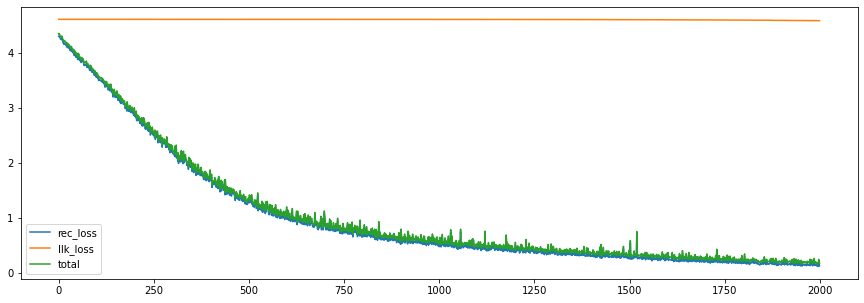

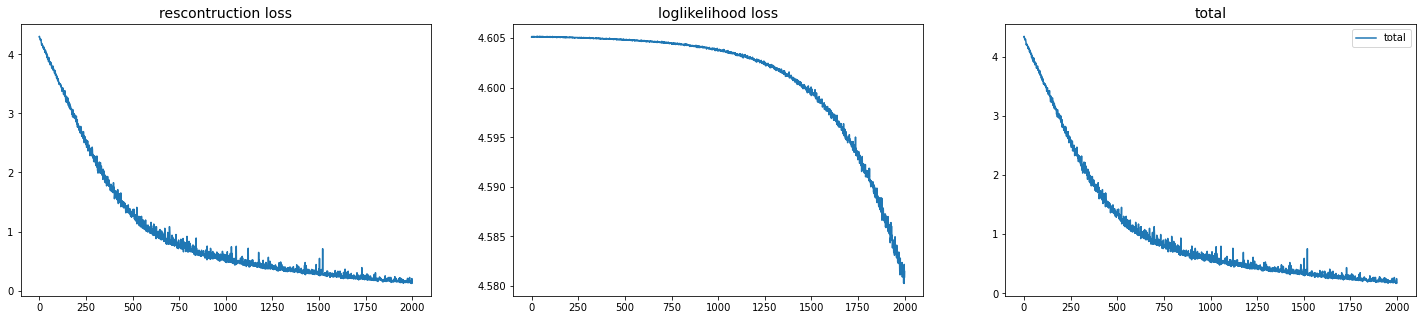

In [30]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rec_loss_list, label = 'rec_loss')
plt.plot(llk_loss_list, label = 'llk_loss')
plt.plot(total_loss_list, label = 'total')
plt.legend()
plt.show()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(25, 5))
ax1.set_title('rescontruction loss', fontsize=14)
ax1.plot(rec_loss_list, label = 'rec_loss')
ax2.set_title('loglikelihood loss', fontsize=14)
ax2.plot(llk_loss_list, label = 'llk_loss')
ax3.set_title('total', fontsize=14)
ax3.plot(total_loss_list, label = 'total')
plt.legend()

In [63]:
def result_model(batch_x):
    
    encoder_output = encoder(batch_x, training = False)
    decoder_output = decoder(encoder_output, training = False)

    cpd = estimator(encoder_output, training = False)

    rec_loss = REC_loss(batch_x, decoder_output)
    llk_loss = LLK_loss(encoder_output, cpd)  
    
    return rec_loss, llk_loss

In [30]:
def compute_normalizing_coefficients(x_val):
    # type: (int) -> Tuple[float, float, float, float]
    """
    Computes normalizing coeffients for the computation of the Novelty score (Eq. 9-10).
    :param cl: the class to be considered normal.
    :return: a tuple of normalizing coefficients in the form (llk_min, llk_max, rec_min, rec_max).
    """

    sample_llk = np.zeros(shape=(len(x_val),))
    sample_rec = np.zeros(shape=(len(x_val),))
    for i in range(len(x_val)):
        
        loss_rec, loss_llk = result_model(x_val[i].reshape(-1, c * img_size * img_size))

        sample_llk[i] = - loss_llk
        sample_rec[i] = - loss_rec 
        i = i + 1
    
    return sample_llk.min(), sample_llk.max(), sample_rec.min(), sample_rec.max()

In [31]:
def novelty_score(sample_llk_norm, sample_rec_norm):
    # type: (np.ndarray, np.ndarray) -> np.ndarray
    """
    Computes the normalized novelty score given likelihood scores, reconstruction scores
    and normalization coefficients (Eq. 9-10).
    :param sample_llk_norm: array of (normalized) log-likelihood scores.
    :param sample_rec_norm: array of (normalized) reconstruction scores.
    :return: array of novelty scores.
    """

    # Sum
    ns = sample_llk_norm + sample_rec_norm

    return ns

In [21]:
def normalize(samples, min, max):
    # type: (np.ndarray, float, float) -> np.ndarray
    """
    Normalize scores as in Eq. 10
    :param samples: the scores to be normalized.
    :param min: the minimum of the desired scores.
    :param max: the maximum of the desired scores.
    :return: the normalized scores
    """
    return (samples - min) / (max - min)

In [42]:
def Detection(label, x_test, y_test, x_val):
    
    min_llk, max_llk, min_rec, max_rec = compute_normalizing_coefficients(x_val)
    
    sample_llk = np.zeros(shape=(len(x_test),))
    sample_rec = np.zeros(shape=(len(x_test),))
    sample_y = np.zeros(shape=(len(x_test),))
    for i in range(len(x_test)):
        
        loss_rec, loss_llk = result_model(x_test[i].reshape(-1, c * img_size * img_size))

        sample_llk[i] = - loss_llk
        sample_rec[i] = - loss_rec
        sample_y[i] = (y_test[i] == label)
        i = i + 1
    

    # Normalize scores
    sample_llk = normalize(sample_llk, min_llk, max_llk).astype('f')
    sample_rec = normalize(sample_rec, min_rec, max_rec).astype('f')

    # Compute the normalized novelty score
    sample_ns = novelty_score(sample_llk, sample_rec).astype('f')

    # Compute AUROC for this class
    this_class_metrics = [
        roc_auc_score(sample_y, sample_llk),  # likelihood metric
        roc_auc_score(sample_y, sample_rec),  # reconstruction metric
        roc_auc_score(sample_y, sample_ns)    # novelty score
    ]
    return  this_class_metrics

In [81]:
log = []

for clazz in ["IMG_4", "IMG_8", "IMG_6", "IMG_22", "IMG_10", "IMG_11" , "IMG_12", "IMG_16" , "IMG_20", "IMG_25"]:

    X_ = np.load(f"./data/{clazz}_X96.npy")
    X_valid_ = np.load(f"./data/{clazz}_X_val96.npy")
    X_test_ = np.load(f"./data/{clazz}_X_test96.npy")


    x_train = X_[100:]
    x_val = X_[:100]

    x_test = np.vstack([ X_valid_, X_test_])
    y_test = np.concatenate([np.zeros(len(X_valid_)), np.ones(len(X_valid_))])

    img_size = 96
    x_train = x_train.reshape((-1, 3, img_size * img_size))[:, 0:3, :].transpose(0,2,1).copy().reshape(-1, 3*img_size*img_size).copy()
    x_test = x_test.reshape((-1, 3, img_size * img_size))[:, 0:3, :].transpose(0,2,1).copy().reshape(-1, 3*img_size*img_size).copy()
    x_val = x_val.reshape((-1, 3, img_size * img_size))[:, 0:3, :].transpose(0,2,1).copy().reshape(-1, 3*img_size*img_size).copy()


    train_buf = x_train.shape[0]
    print(x_train.shape)
    print(train_buf)

    batch_size = 100
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
    train_dataset = train_dataset.shuffle(buffer_size=train_buf)
    train_dataset = train_dataset.batch(batch_size)
    
    encoder = make_encoder()
    decoder = make_decoder()
    estimator = make_estimator()
    
    
    @tf.function
    def update_model(batch_x):

        with tf.GradientTape() as m_tape:
            encoder_output = encoder(batch_x, training=True)
            decoder_output = decoder(encoder_output, training=True)

            cpd = estimator(encoder_output, training=True)

            rec_loss = REC_loss(batch_x, decoder_output)
            llk_loss = LLK_loss(encoder_output, cpd)  
            total_loss = LLK_loss_weight * llk_loss + REC_loss_weight * rec_loss

        m_grads = m_tape.gradient(total_loss, encoder.trainable_variables + decoder.trainable_variables + estimator.trainable_variables)
        m_optimizer.apply_gradients(zip(m_grads, encoder.trainable_variables + decoder.trainable_variables + estimator.trainable_variables))

        return rec_loss, llk_loss, total_loss
    
    train(n_epochs=3000)
    
    the_class_metrics = Detection(0, x_test, y_test, x_val)
    
    log.append(the_class_metrics)
    print(log[-1])
    

(900, 27648)
900

make_estimator
continue
   0: TIME: 5.11 rec_loss: 1.8207058906555176 llk_loss: 4.605161190032959 total_loss: 1.8667575120925903
 100: TIME: 0.60 rec_loss: 0.8309800028800964 llk_loss: 4.605116844177246 total_loss: 0.8770310878753662
 200: TIME: 0.59 rec_loss: 0.5404818058013916 llk_loss: 4.6050639152526855 total_loss: 0.5865324139595032
 300: TIME: 0.57 rec_loss: 0.38910138607025146 llk_loss: 4.605016708374023 total_loss: 0.4351515769958496
 400: TIME: 0.58 rec_loss: 0.29709532856941223 llk_loss: 4.604947090148926 total_loss: 0.3431447744369507
 500: TIME: 0.59 rec_loss: 0.23547418415546417 llk_loss: 4.60486364364624 total_loss: 0.28152281045913696
 600: TIME: 0.59 rec_loss: 0.19096466898918152 llk_loss: 4.604768753051758 total_loss: 0.2370123565196991
 700: TIME: 0.58 rec_loss: 0.15143829584121704 llk_loss: 4.604654312133789 total_loss: 0.1974848210811615
 800: TIME: 0.57 rec_loss: 0.11989572644233704 llk_loss: 4.604496955871582 total_loss: 0.16594070196151733
 900:

1500: TIME: 0.57 rec_loss: 0.13053084909915924 llk_loss: 4.595624923706055 total_loss: 0.17648708820343018
1600: TIME: 0.58 rec_loss: 0.11306644976139069 llk_loss: 4.592580795288086 total_loss: 0.15899226069450378
1700: TIME: 0.55 rec_loss: 0.09554257988929749 llk_loss: 4.588932037353516 total_loss: 0.14143188297748566
1800: TIME: 0.56 rec_loss: 0.08614521473646164 llk_loss: 4.58405065536499 total_loss: 0.13198570907115936
1900: TIME: 0.55 rec_loss: 0.07354218512773514 llk_loss: 4.577847480773926 total_loss: 0.11932064592838287
continue
2000: TIME: 0.57 rec_loss: 0.06511855870485306 llk_loss: 4.571651458740234 total_loss: 0.11083507537841797
2100: TIME: 0.56 rec_loss: 0.05816180258989334 llk_loss: 4.563785076141357 total_loss: 0.10379965603351593
2200: TIME: 0.55 rec_loss: 0.052870333194732666 llk_loss: 4.556820392608643 total_loss: 0.09843853861093521
2300: TIME: 0.55 rec_loss: 0.045123081654310226 llk_loss: 4.549167156219482 total_loss: 0.09061475843191147
2400: TIME: 0.55 rec_loss: 

[0.505655, 0.506879, 0.521756]
(900, 27648)
900

make_estimator
continue
   0: TIME: 5.17 rec_loss: 2.4240283966064453 llk_loss: 4.605154991149902 total_loss: 2.4700798988342285
 100: TIME: 0.62 rec_loss: 1.1571775674819946 llk_loss: 4.60510778427124 total_loss: 1.2032285928726196
 200: TIME: 0.58 rec_loss: 0.7333961725234985 llk_loss: 4.6050286293029785 total_loss: 0.7794464230537415
 300: TIME: 0.58 rec_loss: 0.5344434976577759 llk_loss: 4.604976654052734 total_loss: 0.5804932713508606
 400: TIME: 0.59 rec_loss: 0.4230310618877411 llk_loss: 4.604885578155518 total_loss: 0.469079852104187
 500: TIME: 0.60 rec_loss: 0.3534834682941437 llk_loss: 4.604785442352295 total_loss: 0.3995313048362732
 600: TIME: 0.61 rec_loss: 0.30376487970352173 llk_loss: 4.604644298553467 total_loss: 0.3498113453388214
 700: TIME: 0.59 rec_loss: 0.2646445631980896 llk_loss: 4.60445499420166 total_loss: 0.3106890916824341
 800: TIME: 0.59 rec_loss: 0.22987288236618042 llk_loss: 4.604240417480469 total_loss: 0

1500: TIME: 0.58 rec_loss: 0.016438554972410202 llk_loss: 4.601896286010742 total_loss: 0.06245750933885574
1600: TIME: 0.58 rec_loss: 0.015030326321721077 llk_loss: 4.600934028625488 total_loss: 0.06103966012597084
1700: TIME: 0.59 rec_loss: 0.013798578642308712 llk_loss: 4.599915504455566 total_loss: 0.0597977377474308
1800: TIME: 0.58 rec_loss: 0.012792980298399925 llk_loss: 4.598501205444336 total_loss: 0.05877798795700073
1900: TIME: 0.60 rec_loss: 0.012332473881542683 llk_loss: 4.596639156341553 total_loss: 0.05829886719584465
continue
2000: TIME: 0.64 rec_loss: 0.011680199764668941 llk_loss: 4.594244003295898 total_loss: 0.05762263759970665
2100: TIME: 0.58 rec_loss: 0.010895984247326851 llk_loss: 4.59165096282959 total_loss: 0.05681249126791954
2200: TIME: 0.63 rec_loss: 0.010344963520765305 llk_loss: 4.588670253753662 total_loss: 0.05623166263103485
2300: TIME: 0.64 rec_loss: 0.010137651115655899 llk_loss: 4.585094928741455 total_loss: 0.05598859488964081
2400: TIME: 0.60 rec_

[0.5798615, 0.726228, 0.647182]
